In [13]:
# Import necessary packages.
from collections import defaultdict
import numpy as np
import pandas as pd
import torch
import os
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder, VisionDataset
import torchvision.models as models
from collections import defaultdict

# This is for the progress bar.
from tqdm.auto import tqdm
import random
import argparse

CROP_NAME = ['banana', 'carrot', 'corn', 'dragonfruit', 'garlic',
             'guava', 'peanut', 'pineapple', 'pumpkin',
             'rice', 'soybean', 'sugarcane', 'tomato', 'bareland']
CKPT = "/home/lab530/KenYu/aicpu/eff_best.ckpt"
model_type = 'eff' # 'con'
myseed = 5278  # set a random seed for reproducibility
input_size = 224
batch_size = 64
device = "cuda:0"
NORM_MEAN = (0.485, 0.456, 0.406)
NORM_STD  = (0.229, 0.224, 0.225)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

# This transform should be same as train_tfm
test_tfm = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD)
])

class CropDataset(Dataset):
    def __init__(self,path,tfm=test_tfm,files = None):
        super(CropDataset).__init__()
        self.path = path
        self.files = sorted([os.path.join(path,x) for x in os.listdir(path) if x.endswith(".jpg")])
        if files != None:
            self.files = files
        print(f"One {path} sample",self.files[0])
        self.transform = tfm
  
    def __len__(self):
        return len(self.files)
  
    def __getitem__(self,idx):
        fname = self.files[idx]
        im = Image.open(fname)
        im = self.transform(im)
        try:
            label = int(fname.split("/")[-1].split("_")[0])
        except:
            label = -1 # test has no label
        return im, label, fname.split("/")[-1]

In [14]:
class My_Classifier(nn.Module):
    def __init__(self):
        super(My_Classifier, self).__init__()
        # VGG16
        # self.model = models.vgg16_bn(pretrained=False)
        # self.model.classifier[6] = nn.Linear(4096, 11)

        # # Efficient Net
        # self.model = models.efficientnet_b4(pretrained=True)
        # self.model.classifier[1] = nn.Linear(1792, 15)
        
        # Resnet101
        # self.model = models.resnet101(pretrained=False)
        # self.model.fc = nn.Linear(2048, 11)
        
        # Efficient Net
        if model_type == 'eff':
            self.model = models.efficientnet_b4(pretrained=True)
            self.model.classifier[1] = nn.Linear(1792, 14)
        elif model_type == 'con':
            # ConvNext
            self.model = models.convnext_base(pretrained=True)
            self.model.classifier[2] = nn.Linear(1024, 14)
        elif model_type == 'vit':
            self.model = models.vit_b_16(pretrained=True)
            print(self.model)
        
    def forward(self, x):
        x = self.model(x)
        return x

In [15]:
###################
### Testing Set ###
###################
_dataset_dir = "./data"
test_set = CropDataset(os.path.join(_dataset_dir,"training"), tfm=test_tfm)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

# Testing and generate prediction CSV
model_best = My_Classifier().to(device)
model_best.load_state_dict(torch.load(CKPT))
model_best.eval()

file_names = sorted(os.listdir(os.path.join(_dataset_dir, "training")))

valid_accs = []
predict_label = []
predict_fn = []
last_layer = []
for batch in test_loader:
    imgs, labels, fn = batch
    with torch.no_grad():
        logits = model_best(imgs.to(device))
    # Calcalate Validation
    acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
    valid_accs.append(acc)
    # Output predict
    test_label = np.argmax(logits.cpu().data.numpy(), axis=1)
    for i, y_pred in enumerate(test_label.squeeze().tolist()):
        predict_fn.append(fn[i])
        predict_label.append(y_pred)
        last_layer.append(logits[i].tolist())
    print(f"{len(predict_fn)}/{len(test_loader)}")
    
valid_acc = sum(valid_accs) / len(valid_accs)

# Print the information.
print(f"Validation accuracy = {valid_acc:.5f}")


df = pd.DataFrame()
for i in range(len(predict_fn)):
    df["Id"] = predict_fn
    df["Category"] = predict_label
    df["last_layer"] = last_layer
df.to_csv(f"eff_training.csv", index = False)

One ./data/training sample ./data/training/0_10006.jpg
64/1005
128/1005
192/1005
256/1005
320/1005
384/1005
448/1005


KeyboardInterrupt: 

## Metric: weight precision

In [ ]:
CROP_NAME = ['banana', 'carrot', 'corn', 'dragonfruit', 'garlic',
             'guava', 'peanut', 'pineapple', 'pumpkin',
             'rice', 'soybean', 'sugarcane', 'tomato', 'bareland', 'inundated']
# Get y_pred, y_label from submit.csv
y_pd = []
y_gt = []
with open("epoch_0_submit.csv", 'r') as f: 
    f.readline() # First line
    for line in f.readlines():
        (fn, pred_str) = line.split(',')
        label = int(fn.split('_')[0])
        pred  = int(pred_str)
        y_pd.append(pred)
        y_gt.append(label)

# Calculate Precision for every classes.
from collections import defaultdict
pd_class = defaultdict(lambda:[0, 0]) # {<cls>: [<TP>, <FP>]}
gt_class = defaultdict(int) # [<cls> : <number of label>]
for i, pred in enumerate(y_pd):
    if y_gt[i] == pred:
        pd_class[pred][0] += 1
    else:
        pd_class[pred][1] += 1
    gt_class[ y_gt[i] ] += 1
# print(pd_class)
# print(gt_class)

# Calculate weight precision
weight_precision = 0
for cls in gt_class:
    tp, fp = pd_class[cls]
    precision = tp / (tp + fp)
    weight = gt_class[cls] / len(y_pd)
    weight_precision += precision*weight
    print(f"{CROP_NAME[cls]} precision = {round(precision*100,4)}%, propotion =  {round(weight*100,4)}%")
    # print(f"{CROP_NAME[cls]} weighted precision = {weight_precision}")
print(f"weight_precision = {weight_precision}")


banana precision = 99.2415%, propotion =  5.0252%
soybean precision = 85.8009%, propotion =  7.0402%
sugarcane precision = 97.9592%, propotion =  2.5686%
tomato precision = 86.3768%, propotion =  1.9404%
bareland precision = 97.0238%, propotion =  11.7358%
inundated precision = 90.6091%, propotion =  4.5214%
carrot precision = 88.5167%, propotion =  2.4628%
corn precision = 96.2886%, propotion =  11.9348%
dragonfruit precision = 97.7337%, propotion =  2.2016%
garlic precision = 96.438%, propotion =  9.3725%
guava precision = 97.8791%, propotion =  5.8897%
peanut precision = 94.6746%, propotion =  12.7931%
pineapple precision = 99.1406%, propotion =  10.1561%
pumpkin precision = 91.8919%, propotion =  2.3136%
rice precision = 99.6855%, propotion =  10.0442%
weight_precision = 0.956494111559163


## Confusion Matrix

In [ ]:
#Plot the confusion matrix. Set Normalize = True/False
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(20,20))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Print the Target names
from sklearn.metrics import classification_report, confusion_matrix
import itertools 
#shuffle=False

# Get y_pred, y_label from submit.csv
y_pd = []
y_gt = []
with open("epoch_0_submit.csv", 'r') as f: 
    print (f.readline()) # First line
    for line in f.readlines():
        (fn, pred_str) = line.split(',')
        label = int(fn.split('_')[0])
        pred  = int(pred_str)
        y_pd.append(pred)
        y_gt.append(label)

cm = confusion_matrix(y_gt, y_pd)
plot_confusion_matrix(cm, CROP_NAME, title='Confusion Matrix')




ModuleNotFoundError: No module named 'matplotlib'

## Show wrongly classfiy images 

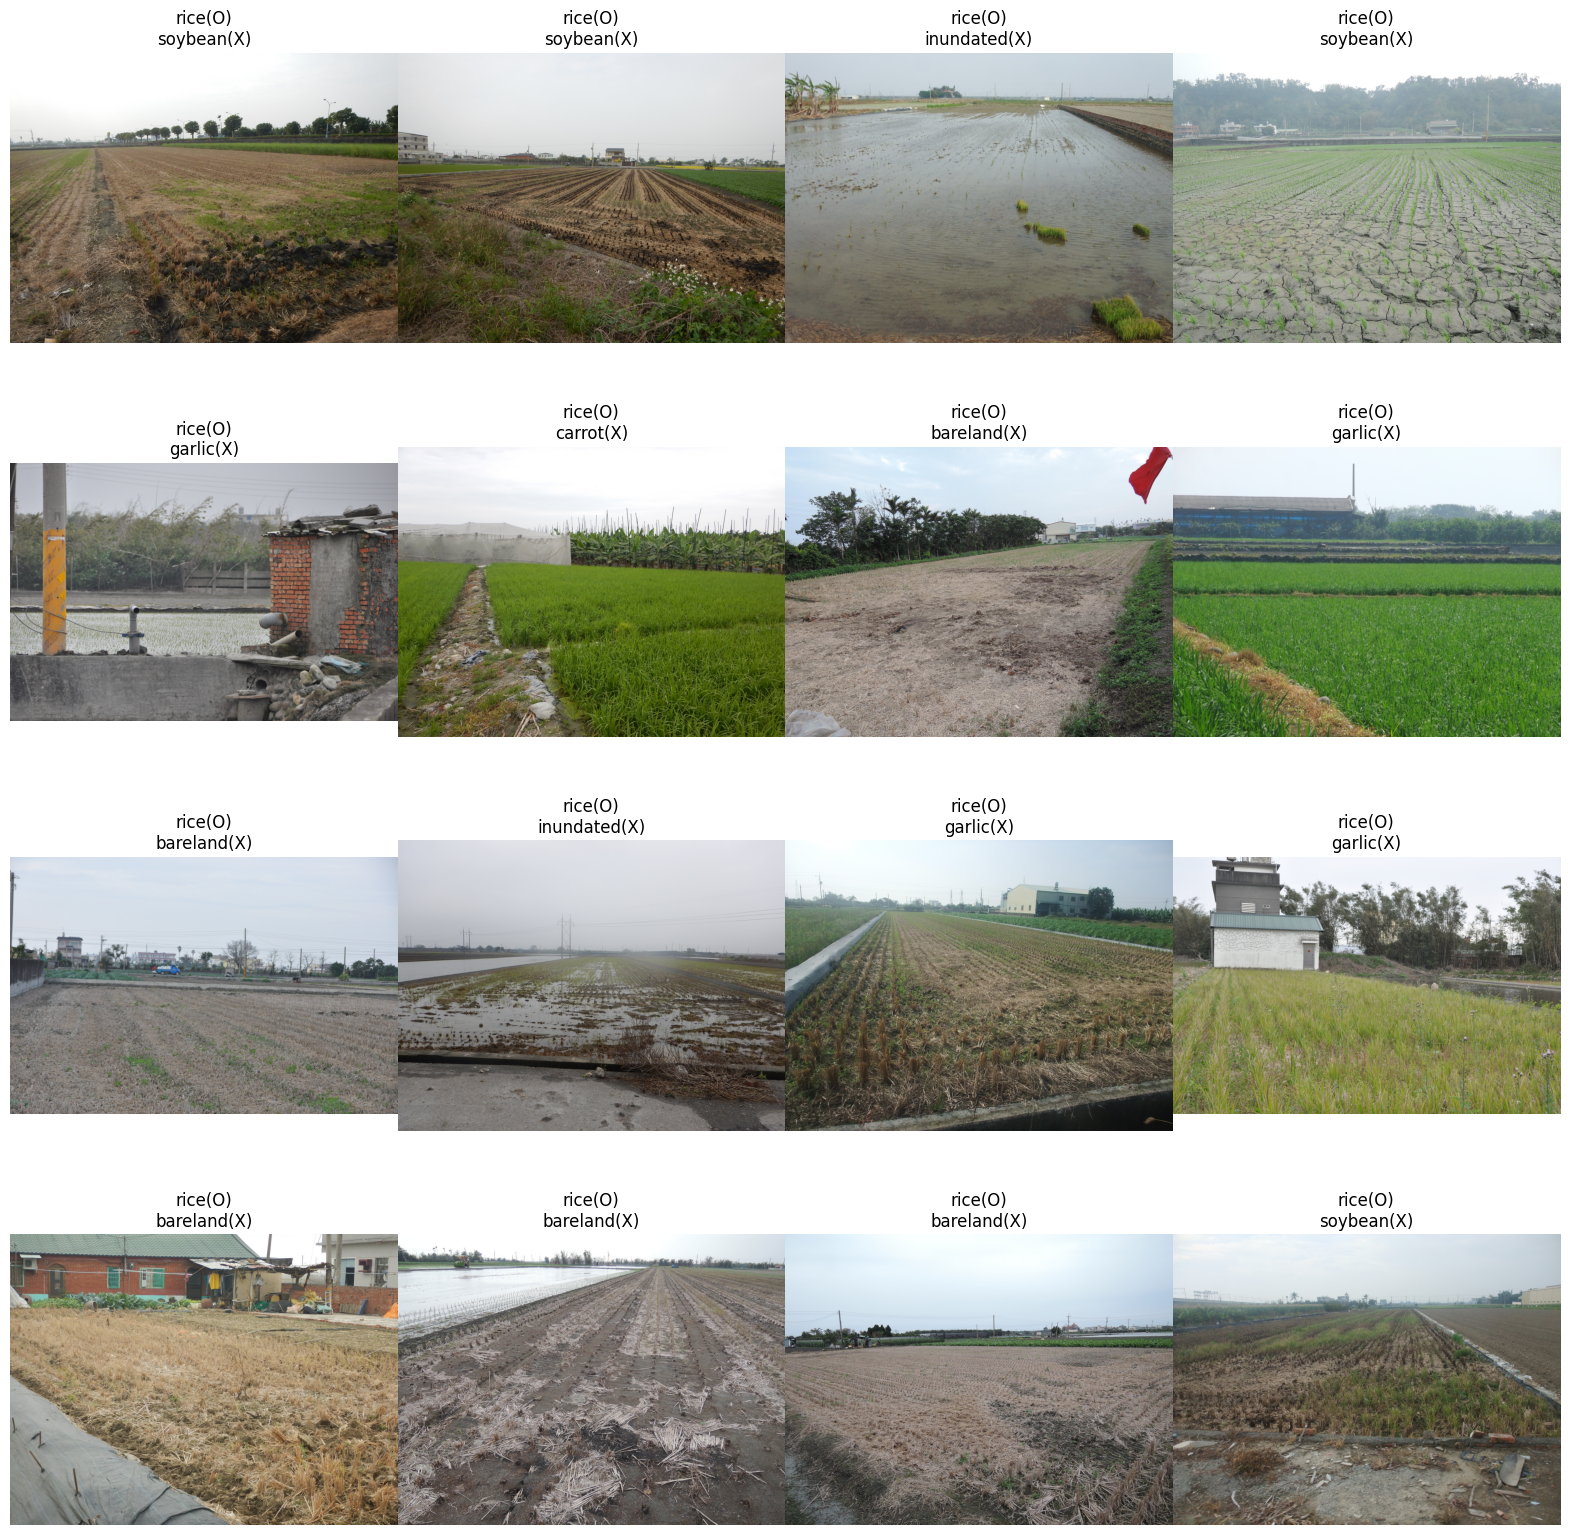

: 

In [ ]:
error_list = []
with open("epoch_0_submit.csv", 'r') as f: 
    f.readline() # Ignore First line
    for line in f.readlines():
        (fn, pred_str) = line.split(',')
        label = int(fn.split('_')[0])
        pred  = int(pred_str)
        if label != pred: # Wrongly classify
            error_list.append((fn, label, pred))
# print(f"Total number of Error: {len(error_list)}")

import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from PIL import Image
from shutil import rmtree
_dataset_dir = "./data"
CROP_NAME = ['banana', 'carrot', 'corn', 'dragonfruit', 'garlic',
             'guava', 'peanut', 'pineapple', 'pumpkin',
             'rice', 'soybean', 'sugarcane', 'tomato', 'bareland', 'inundated']
OUTPUT_DIR = "output/"
if os.path.isdir(OUTPUT_DIR):
    rmtree(OUTPUT_DIR)
os.mkdir(OUTPUT_DIR)

fig = plt.figure(figsize=(20, 20) , dpi=100)
# fig.tight_layout()
fig.patch.set_facecolor('white')

gs = GridSpec(4, 4)
gs.update(wspace=0)  # set the spacing between axes.
ax_list = []
for ii in range(16):
    ax_list.append( fig.add_subplot(gs[ii//4, ii%4]) )
    ax_list[-1].axis('off')

for i in range(0, len(error_list), 16):
    for ii, err_case in enumerate(error_list[i:i+16]):
        ax_list[ii].set_title(f"{CROP_NAME[err_case[1]] }(O)\n{CROP_NAME[err_case[2]]}(X)", fontsize=12)
        ax_list[ii].imshow(Image.open( os.path.join(_dataset_dir, "validation", err_case[0]) ).convert('RGB'), alpha=1)
    fig.savefig(os.path.join(OUTPUT_DIR, f"{i}.png"), bbox_inches='tight')

